<a href="https://colab.research.google.com/github/milvish/MN_lab_4/blob/main/Mobile_NW_lab4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil
import os

directory_path = "/content/sample_data"  # Path to the directory you want to delete

# Remove all the files and subdirectories within the directory
shutil.rmtree(directory_path)

# Verify if the directory has been deleted
if not os.path.exists(directory_path):
    print("Directory deleted successfully!")
else:
    print("Failed to delete the directory.")

Directory deleted successfully!


In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
from zipfile import ZipFile
from google.colab import drive
drive.mount('/content/drive')
file_name = 'drive/MyDrive/Colab Notebooks/NW_lab4/teddy_bird.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('datasets')
  print('Done')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done


Ultralytics

In [ ]:
!pip install ultralytics

Visualize Images from the Dataset

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[1:]
                #print(bbox_string.split(' '))
                empty_par,x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

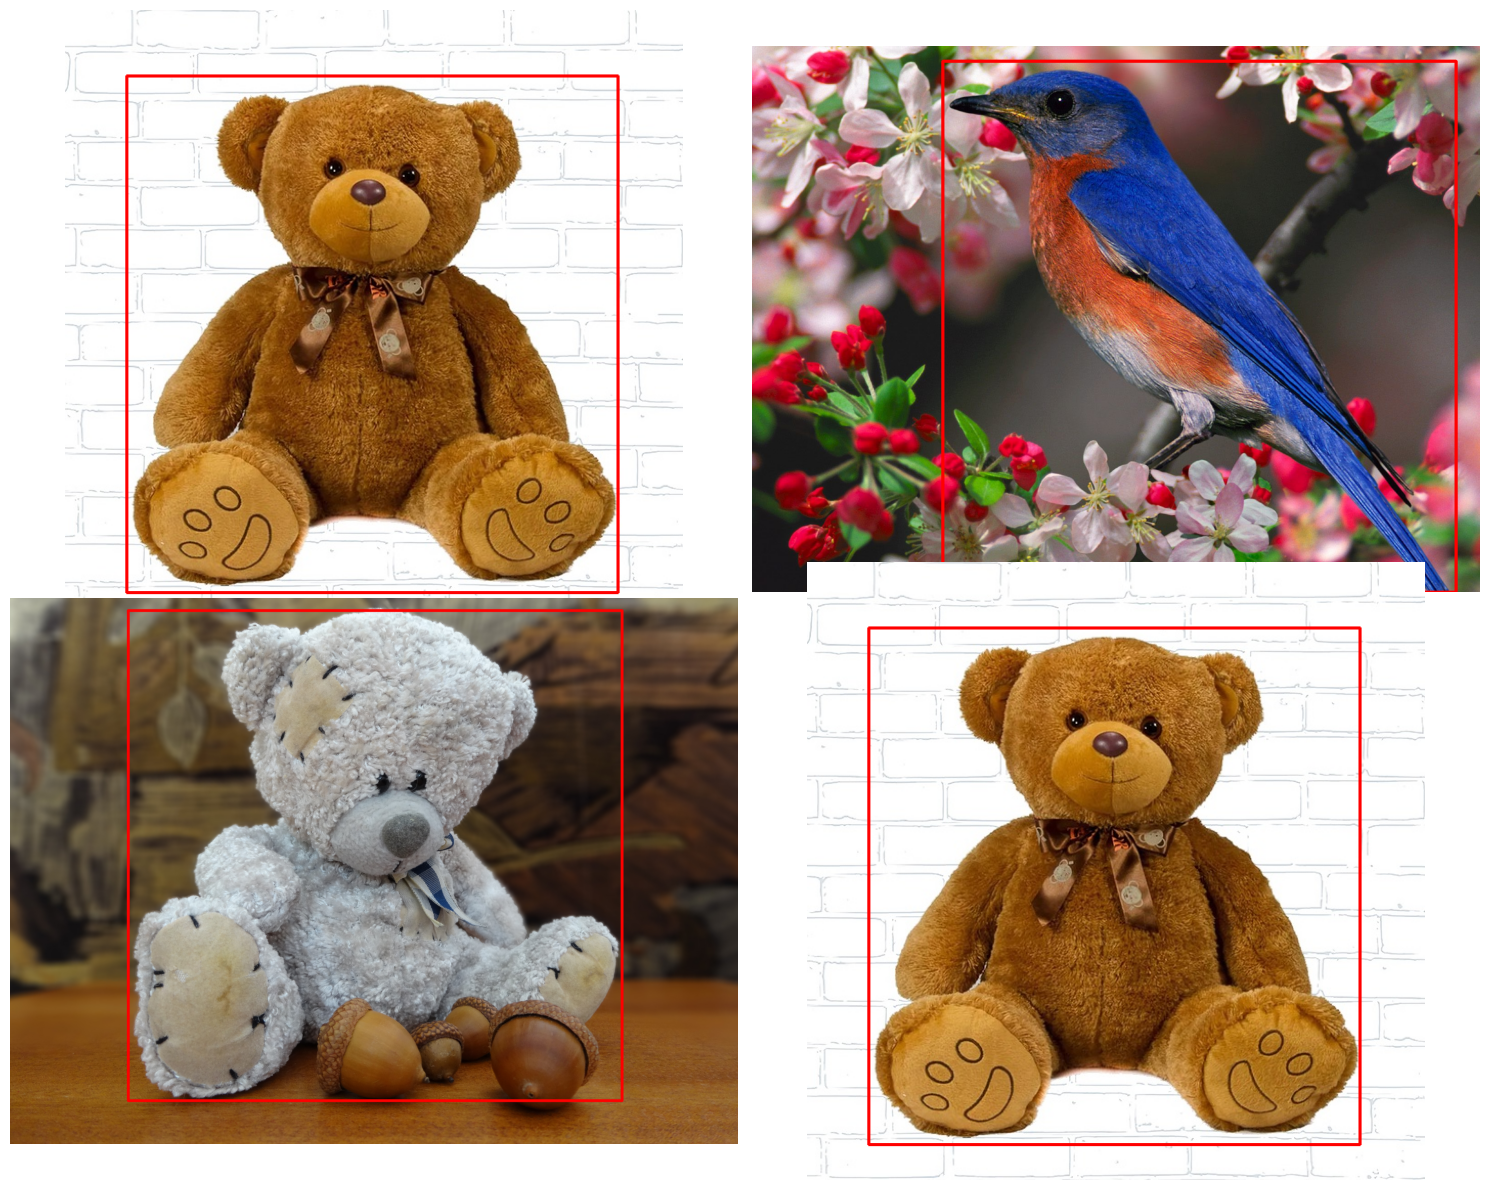

In [ ]:
# Visualize a few training images.
plot(
    image_paths='datasets/teddy_bird/train/images/',
    label_paths='datasets/teddy_bird/train/labels/',
    num_samples=4,
)

YOLOv8 Training

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=datasets/pothole_v8.yaml epochs=50 batch=8 name=yolov8n_v8_50e

100% 6.23M/6.23M [00:00<00:00, 219MB/s]
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/pothole_v8.yaml, epochs=50, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

Evaluation on Validation Images

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=datasets/pothole_v8.yaml

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/datasets/teddy_bird/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100% 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:04<00:00,  2.35s/it]
                   all         20         20      0.758       0.75      0.853      0.292
            teddy bear         20         10      0.758        0.7      0.815      0.269
                  bird         20         10      0.758        0.8       0.89      0.315
Speed: 36.6ms preprocess, 35.6ms inference, 0.0ms loss, 64.3ms postprocess per image
Results saved to runs/detect/yolov8n_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


Inference on Validation Images

In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e/weights/best.pt \
source=datasets/teddy_bird/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
show_labels=True

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/20 /content/datasets/teddy_bird/valid/images/b21.jpg: 1024x1280 2 birds, 99.8ms
image 2/20 /content/datasets/teddy_bird/valid/images/b22.jpg: 1024x1280 (no detections), 15.6ms
image 3/20 /content/datasets/teddy_bird/valid/images/b23.jpg: 800x1280 1 bird, 62.5ms
image 4/20 /content/datasets/teddy_bird/valid/images/b24.jpg: 1120x1280 1 bird, 61.1ms
image 5/20 /content/datasets/teddy_bird/valid/images/b25.jpg: 928x1280 1 bird, 60.5ms
image 6/20 /content/datasets/teddy_bird/valid/images/b26.jpg: 1280x928 2 birds, 58.1ms
image 7/20 /content/datasets/teddy_bird/valid/images/b27.jpg: 800x1280 1 bird, 14.6ms
image 8/20 /content/datasets/teddy_bird/valid/images/b28.jpg: 864x1280 2 birds, 62.3ms
image 9/20 /content/datasets/teddy_bird/valid/images/b29.jpg: 1280x1280 2 birds, 20.1ms

Vizualize Validation Results

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

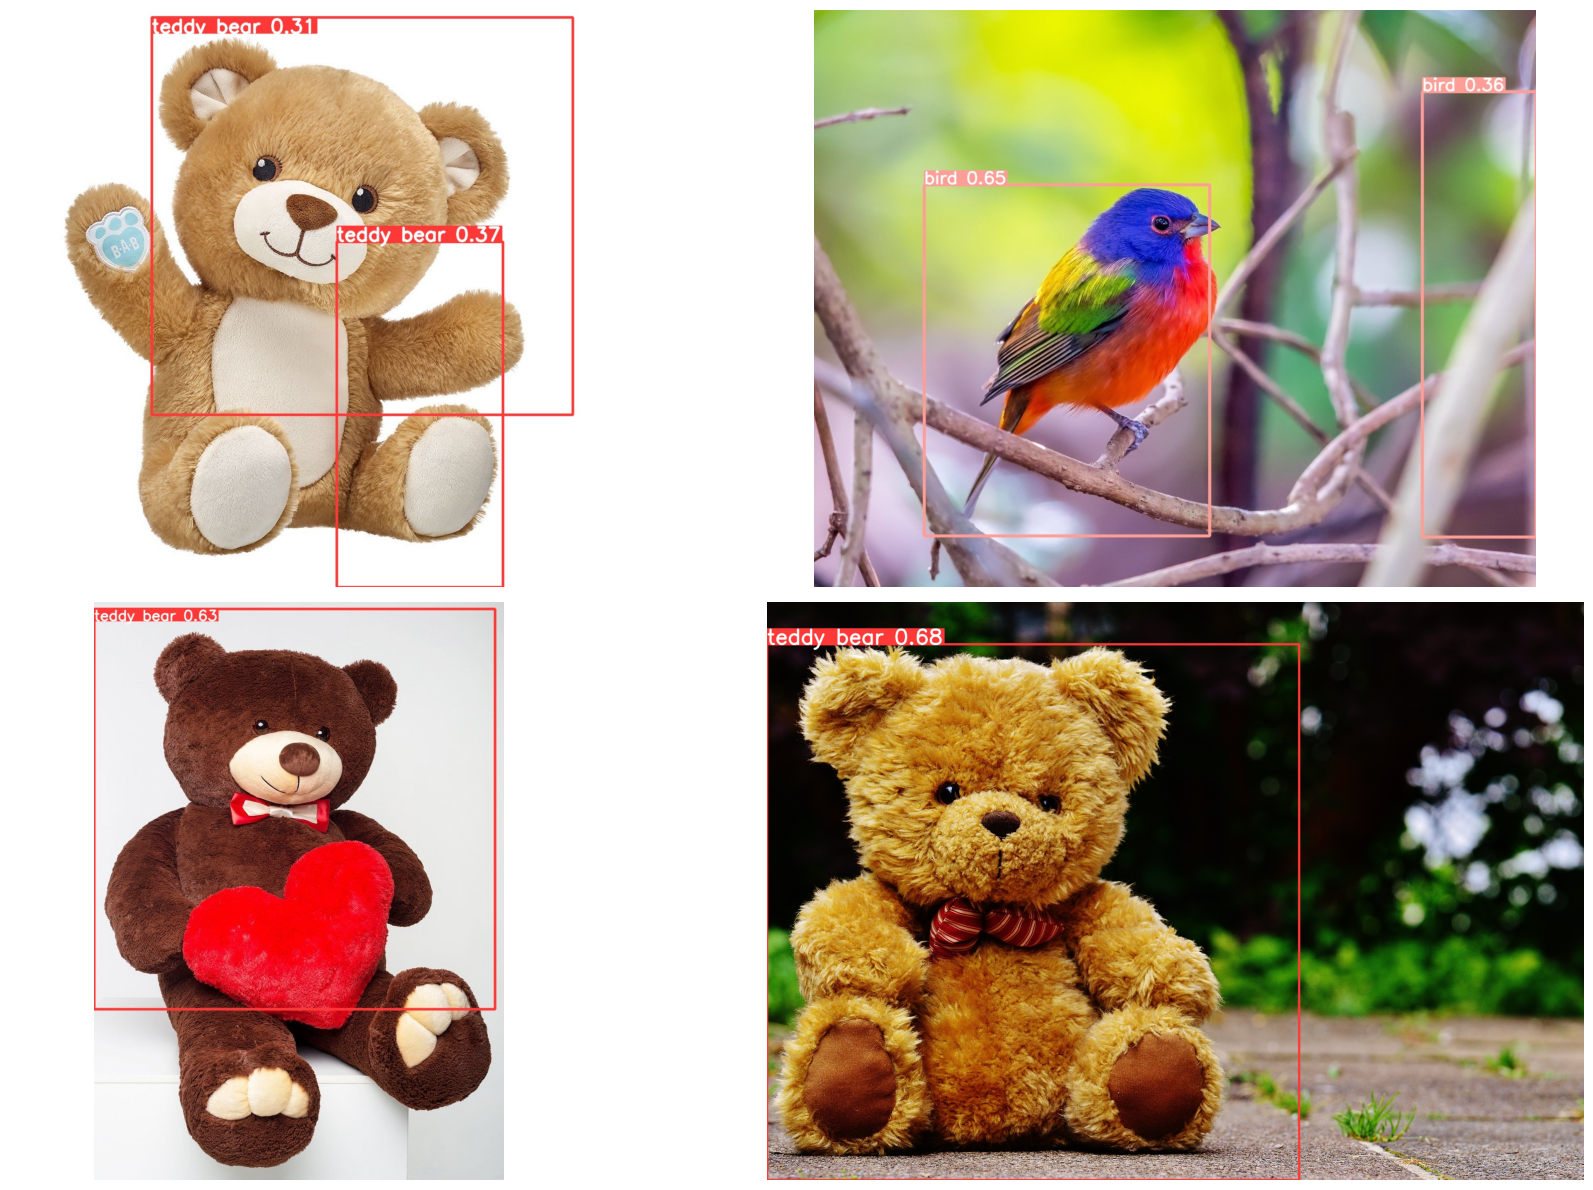

In [ ]:
visualize('runs/detect/yolov8n_v8_50e_infer1280/')

На тестовом изображении

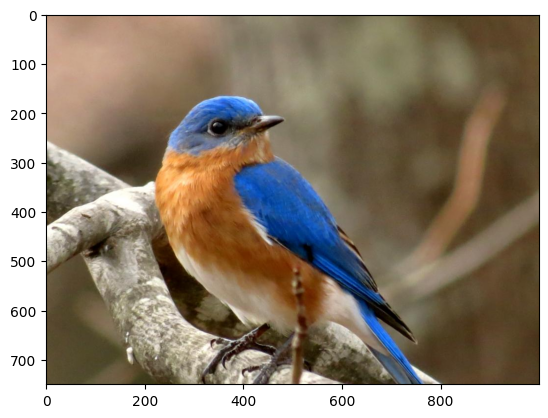

In [ ]:
import numpy as np
import urllib
import cv2
import matplotlib.pyplot as plt
#img_url = "https://pngimg.com/uploads/teddy_bear/teddy_bear_PNG14.png"
#img_url = "https://i.pinimg.com/originals/c1/d9/53/c1d9532e878b5341aefc5eaa4534eb0b.jpg"
img_url = "http://mammothbirds.org/uploads/3/4/7/5/34751493/blue2.jpg"
arr = np.array(bytearray(urllib.request.urlopen(img_url).read()), dtype=np.uint8)
img = cv2.imdecode(arr,-1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


0: 960x1280 2 birds, 129.9ms
Speed: 7.6ms preprocess, 129.9ms inference, 2.4ms postprocess per image at shape (1, 3, 960, 1280)


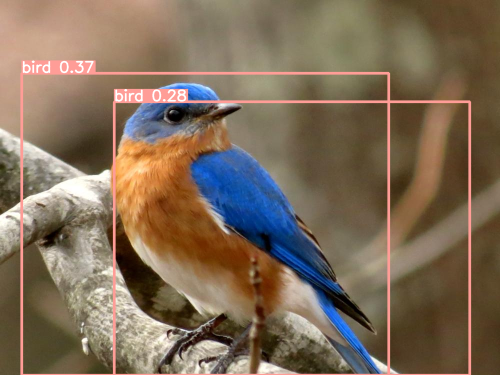

In [ ]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
model_yolo = YOLO('runs/detect/yolov8n_v8_50e/weights/best.pt')
yolo_res = model_yolo([cv2.cvtColor(img, cv2.COLOR_RGB2BGR)])
yolo_res = yolo_res[0].cpu()

detection_visualization = yolo_res.plot()
detection_visualization = cv2.resize(detection_visualization, None, fx=1/2, fy=1/2)

cv2_imshow(detection_visualization)

In [ ]:
import torch
def img2tensor(img: np.ndarray, mean: list, std: list, size: int = 224) -> torch.Tensor:
  t = cv2.resize(img, (size,size), interpolation=cv2.INTER_AREA)
  t = torch.from_numpy(t.astype(np.float32)/ 255.0) # 0..255->0..1
  t = t.permute(2,0,1) # hwc -> chw
  _m = torch.FloatTensor(mean).unsqueeze(1).unsqueeze(1) #cx1x1
  _s = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
  t = (t - _m) / (_s + 1E-7)
  return t

In [ ]:
y = img2tensor(img, mean=[0, 0, 0], std=[1, 1, 1],size=1280).unsqueeze(0)

In [ ]:
import tensorflow as tf
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="/content/runs/detect/yolov8n_v8_50e/weights/best_saved_model/best_float32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_data = np.array(y.permute(0,2,3,1))
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[[  0.0030209    0.016714    0.021789 ...     0.88752     0.90319     0.92646]
  [  0.0083241   0.0028694    0.002422 ...     0.94401     0.94178     0.93916]
  [   0.011199    0.033375    0.038138 ...     0.23042     0.20167     0.14821]
  [   0.015683   0.0052214   0.0045696 ...     0.10957     0.11399     0.11967]
  [ 0.00021566  0.00021202  0.00019543 ...   0.0042075   0.0043997   0.0039648]
  [ 0.00020486  0.00020113  0.00022869 ...   0.0053638   0.0061413   0.0059962]]]


In [ ]:
output_data.shape

(1, 6, 33600)

***

In [ ]:
out = output_data.copy()
out[:, :4, :] *= 640
image = cv2.imread('datasets/teddy_bird/tb26.jpg', cv2.IMREAD_COLOR)

In [ ]:
import torchvision
def xywh2xyxy(x):
  y = np.copy(x)
  y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
  y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
  y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
  y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
  return y

kx = image.shape[1] / 640
ky = image.shape[0] / 640

elem_out = out.transpose(0, 2, 1).squeeze()
print(elem_out.shape)

boxes = elem_out[:, :4] * np.array([[kx, ky, kx, ky]])
boxes = xywh2xyxy(boxes)
probs_max_value = elem_out[:, 4:].max(axis=1)
probs_max_index = elem_out[:, 4:].argmax(axis=1)

threshold = 0.5

filter_mask = probs_max_value > threshold

f_boxes = boxes[filter_mask].astype(np.int32)
f_probs_max_value = probs_max_value[filter_mask]
f_probs_max_index = probs_max_index[filter_mask]

keeps_elements = torchvision.ops.nms(
    torch.from_numpy(f_boxes.astype(np.float32)),
    torch.from_numpy(f_probs_max_value),
    0.5
  )

f_boxes = f_boxes[keeps_elements]
f_probs_max_value = f_probs_max_value[keeps_elements]

if len(f_boxes.shape) == 1:
  f_boxes = f_boxes[None]
  f_probs_max_value = f_probs_max_value[None]

print(f_boxes.shape)

(33600, 6)
(1, 4)


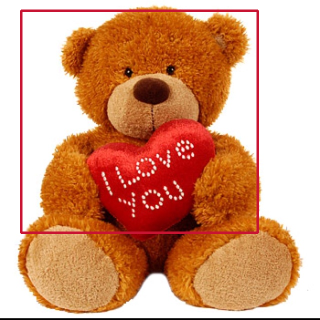

In [ ]:
colors = [(50, 20, 200), (90, 40, 10)]
detection_visualization = image.copy()

for detecion_id in range(len(f_boxes)):
  target_object_box = f_boxes[detecion_id]  # XcYcWH format
  target_object_prob = float(f_probs_max_value[detecion_id])

  detection_visualization = cv2.rectangle(
      detection_visualization,
      tuple(target_object_box[:2]),
      tuple(target_object_box[2:]),
      colors[detecion_id % len(colors)],
      3
  )

detection_visualization = cv2.resize(detection_visualization, None, fx=1/2, fy=1/2)

cv2_imshow(detection_visualization)